# Support Vector Machines

Les SVM (Support vector machines) constituent une classe particulièrement puissante et flexible d'algorithmes supervisés pour la classification et la régression.
Dans cette section, nous allons développer l'intuition derrière les machines à vecteurs de support et leur utilisation dans les problèmes de classification.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Pourquoi les SVM ?


Il s'agissait d'un exemple de *classification générative* ; ici, nous allons plutôt considérer la *classification discriminative* : plutôt que de modéliser chaque classe, nous trouvons simplement une ligne ou une courbe (en deux dimensions) ou un collecteur (en plusieurs dimensions) qui sépare les classes les unes des autres.

À titre d'exemple, considérons le cas simple d'une tâche de classification, dans laquelle les deux classes de points sont bien séparées :

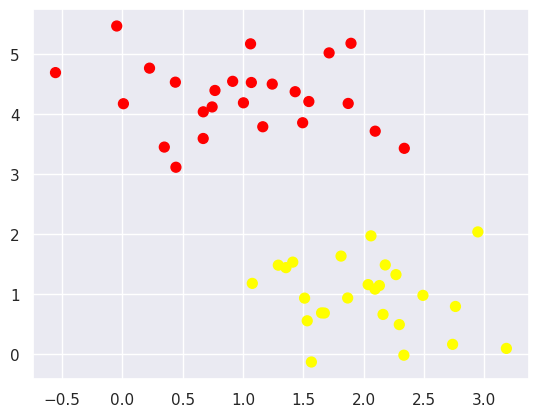

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Un classificateur discriminant linéaire tenterait de tracer une ligne droite séparant les deux ensembles de données, et créerait ainsi un modèle de classification.
Pour des données bidimensionnelles comme celles présentées ici, il s'agit d'une tâche que nous pourrions effectuer à la main.
Mais nous voyons immédiatement un problème : il y a plus d'une ligne de séparation possible qui peut parfaitement discriminer entre les deux classes !

Nous pouvons les dessiner comme suit :

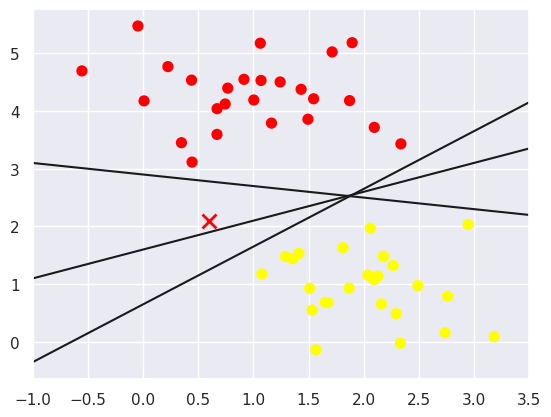

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Il s'agit de trois séparateurs différents qui, néanmoins, discriminent parfaitement ces échantillons.
Selon celui que vous choisissez, un nouveau point de données (par exemple, celui marqué par le "X" dans ce graphique) se verra attribuer une étiquette différente !
De toute évidence, notre simple intuition consistant à "tracer une ligne entre les classes" n'est pas suffisante, et nous devons réfléchir un peu plus en profondeur.

## SVM : Maximiser la marge

Les SVM offrent un moyen d'améliorer cette situation.
L'intuition est la suivante : plutôt que de simplement tracer une ligne de largeur nulle entre les classes, nous pouvons tracer autour de chaque ligne une *marge* d'une certaine largeur, jusqu'au point le plus proche.
Voici un exemple de ce que cela pourrait donner :

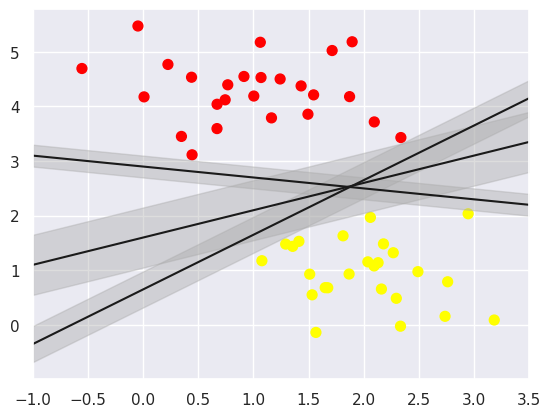

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Dans les SVM, la ligne qui maximise cette marge est celle que nous choisirons comme modèle optimal.
Les machines à vecteurs de support sont un exemple d'un tel estimateur à *marge maximale*.

### Ajustement d'un SVM

Voyons le résultat d'un ajustement réel de ces données : nous allons utiliser le SVM de Scikit-Learn pour entraîner un modèle SVM sur ces données.
Pour l'instant, nous utiliserons un noyau linéaire et nous fixerons le paramètre "C" à un nombre très élevé (nous discuterons de la signification de ces paramètres plus en profondeur dans un instant).

In [5]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Pour mieux visualiser ce qui se passe ici, créons une fonction qui tracera les limites de décision du SVM pour nous :

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

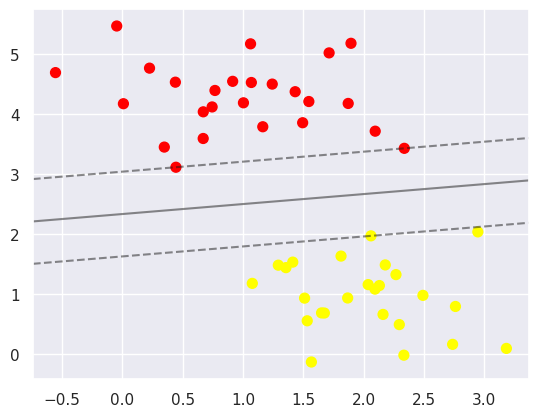

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Il s'agit de la ligne de démarcation qui maximise la marge entre les deux ensembles de points.
Remarquez que quelques points de formation touchent juste la marge.
Ces points sont les éléments pivots de cet ajustement, et sont connus sous le nom de *vecteurs de soutien*, et donnent son nom à l'algorithme.
Dans Scikit-Learn, l'identité de ces points est stockée dans l'attribut ``support_vectors_`` du classificateur :

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

L'une des clés du succès de ce classificateur est que, pour l'ajustement, seule la position des vecteurs de support compte ; tous les points plus éloignés de la marge qui sont du bon côté ne modifient pas l'ajustement !
Techniquement, c'est parce que ces points ne contribuent pas à la fonction de perte utilisée pour ajuster le modèle, donc leur position et leur nombre n'ont pas d'importance tant qu'ils ne traversent pas la marge.

Nous pouvons le constater, par exemple, si nous traçons le modèle appris à partir des 60 premiers points et des 120 premiers points de cet ensemble de donnée

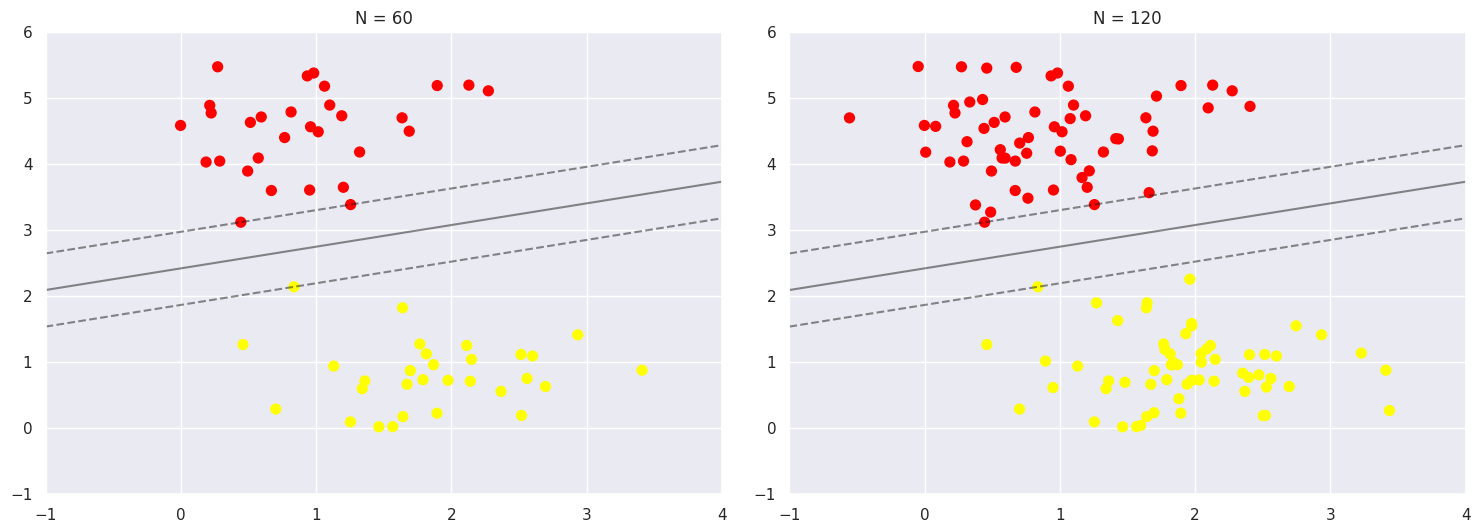

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

Dans le panneau de gauche, nous voyons le modèle et les vecteurs de support pour 60 points d'apprentissage.
Dans le panneau de droite, nous avons doublé le nombre de points d'apprentissage, mais le modèle n'a pas changé : les trois vecteurs de support du panneau de gauche sont toujours les vecteurs de support du panneau de droite.
Cette insensibilité au comportement exact des points éloignés est l'une des forces du modèle SVM.

Si vous exécutez ce notebook en direct, vous pouvez utiliser les widgets interactifs d'IPython pour visualiser cette caractéristique du modèle SVM de manière dynamique :

interactive(children=(Dropdown(description='N', options=(10, 800), value=10), Output()), _dom_classes=('widget…

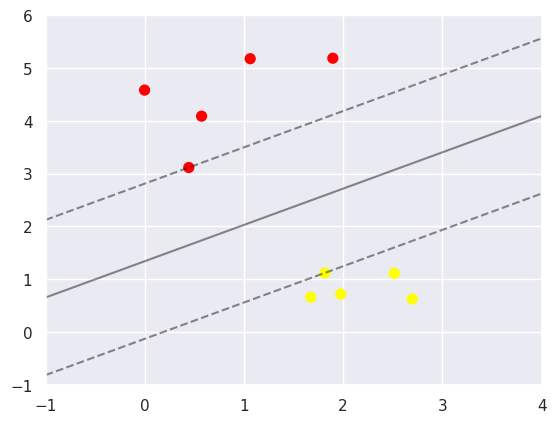

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 800], ax=fixed(None));

### Au-delà des limites linéaires : SVM à noyau

Le SVM devient extrêmement puissant lorsqu'il est combiné avec des *noyaux*.
Pour expliquer la nécessité des noyaux, examinons des données qui ne sont pas linéairement séparables :

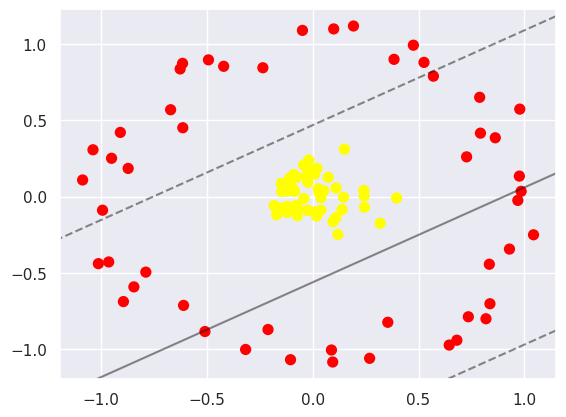

In [11]:
from sklearn.datasets import make_circles

X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Il est clair qu'aucune discrimination linéaire ne sera *jamais* en mesure de séparer ces données.
Par exemple, une projection simple que nous pourrions utiliser consisterait à calculer une *fonction de base radiale* centrée sur la masse centrale :

In [12]:
r = np.exp(-(X ** 2).sum(1))

Nous pouvons visualiser cette dimension supplémentaire des données à l'aide d'un graphique tridimensionnel. Si vous exécutez ce bloc-notes en direct, vous pourrez utiliser les curseurs pour faire pivoter le graphique :

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

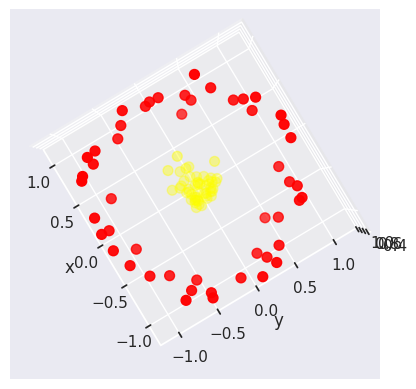

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

Nous pouvons voir qu'avec cette dimension supplémentaire, les données deviennent trivialement linéairement séparables, en traçant un plan de séparation à, disons, *r*=0,7.

Ici, nous avons dû choisir et ajuster soigneusement notre projection : si nous n'avions pas centré notre fonction de base radiale au bon endroit, nous n'aurions pas obtenu des résultats aussi nets et linéairement séparables.
En général, la nécessité de faire un tel choix est un problème : nous aimerions pouvoir trouver automatiquement les meilleures fonctions de base à utiliser.

Une stratégie à cette fin consiste à calculer une fonction de base centrée sur *chaque* point de l'ensemble de données, et à laisser l'algorithme SVM passer les résultats au crible.
Ce type de transformation de la fonction de base est connu sous le nom de *transformation du noyau*, car il est basé sur une relation de similarité (ou noyau) entre chaque paire de points.

Un problème potentiel avec cette stratégie - projeter $N$ points dans $N$ dimensions - est qu'elle peut devenir très intensive en termes de calcul lorsque $N$ devient grand.
Cependant, grâce à une petite procédure astucieuse connue sous le nom de [*kernel trick*] (https://en.wikipedia.org/wiki/Kernel_trick), un ajustement sur des données transformées par le noyau peut être effectué implicitement, c'est-à-dire sans jamais construire la représentation complète à N$ dimensions de la projection du noyau !
Cette astuce de noyau est intégrée au SVM, et c'est l'une des raisons pour lesquelles cette méthode est si performante.

Dans Scikit-Learn, nous pouvons appliquer un SVM à noyau en changeant simplement notre noyau linéaire en un noyau RBF (radial basis function), en utilisant l'hyperparamètre de modèle ``kernel`` :

In [14]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

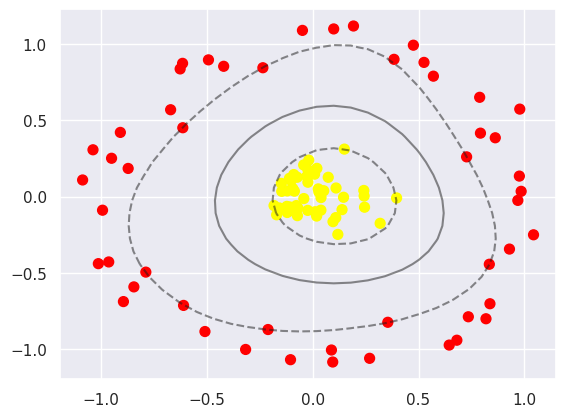

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

En utilisant ce SVM à noyau, nous apprenons une délimitation de décision non linéaire appropriée.
Cette stratégie de transformation par noyau est souvent utilisée en apprentissage automatique pour transformer des méthodes linéaires rapides en méthodes non linéaires rapides, en particulier pour les modèles dans lesquels l'astuce du noyau peut être utilisée.

### Réglage du SVM : Adoucir les marges

Jusqu'à présent, notre discussion s'est concentrée sur des ensembles de données très propres, dans lesquels une frontière de décision parfaite existe.
Mais que se passe-t-il si vos données présentent un certain degré de chevauchement ?
Par exemple, vous pouvez avoir des données comme celles-ci :

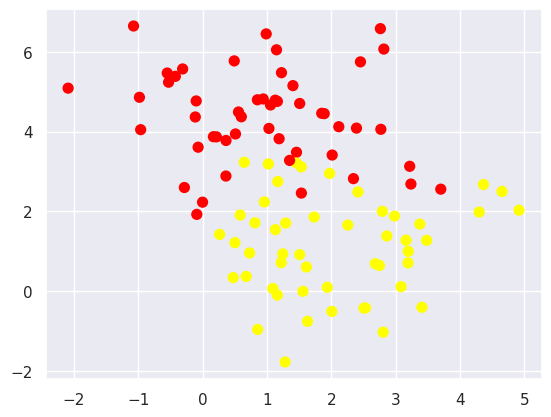

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Pour gérer ce cas, l'implémentation du SVM possède un facteur d'ajustement qui "adoucit" la marge : c'est-à-dire qu'elle permet à certains points de se glisser dans la marge si cela permet un meilleur ajustement.
La dureté de la marge est contrôlée par un paramètre d'ajustement, le plus souvent connu sous le nom de $C$.
Pour une valeur très élevée de $C$, la marge est dure et les points ne peuvent pas s'y trouver.
Pour des $C$ plus petits, la marge est plus souple et peut s'élargir pour englober certains points.

Le graphique ci-dessous donne une image visuelle de la façon dont un paramètre $C$ changeant affecte l'ajustement final, via l'adoucissement de la marge :

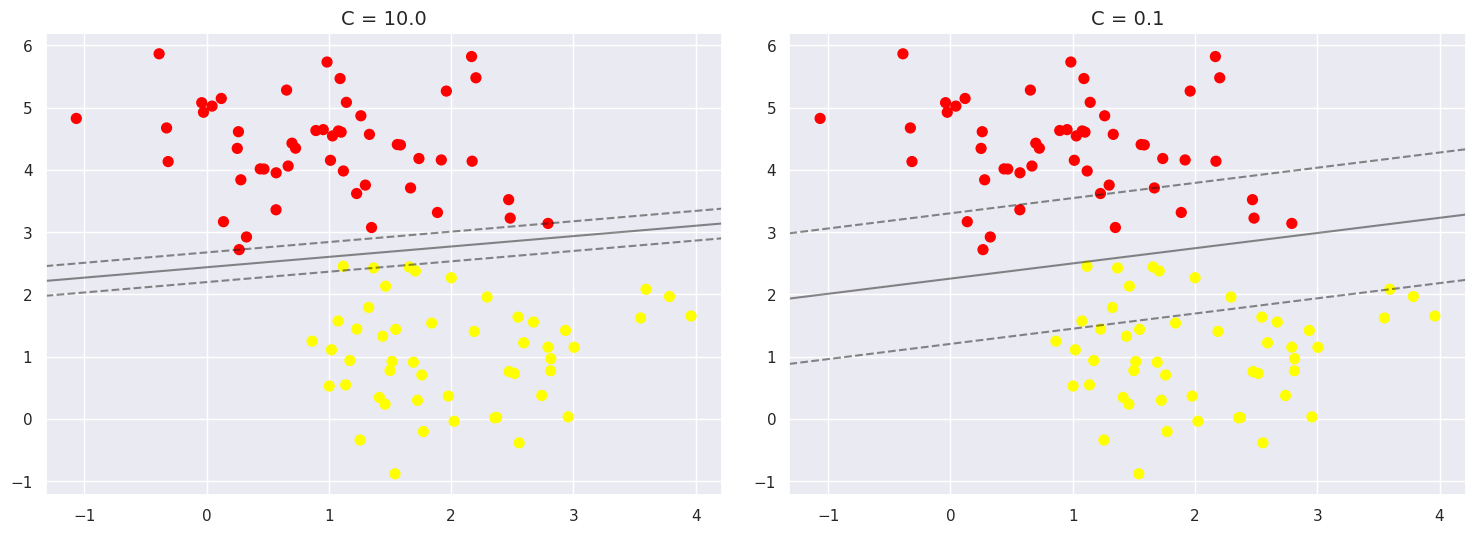

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

La valeur optimale du paramètre $C$ dépendra de votre ensemble de données, et devrait être réglée en utilisant la validation croisée ou une procédure similaire.